In [1]:
import numpy as np
import pandas as pd
import psycopg2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection parameters
db_params = {
    'dbname': 'week1',
    'user': 'postgres',
    'password': 'habte',
    'host': 'localhost',
    'port': '5432'
}

# Create a SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg2://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["dbname"]}')

# SQL query to retrieve data
sql_query = "SELECT * FROM xdr_data;"

# Read data from PostgreSQL into a DataFrame
mydata = pd.read_sql_query(sql_query, engine)

In [4]:
#Aggregate Metrics Per Customer ID and Report Top 10 Customers per Engagement Metric
# Define engagement metrics
engagement_metrics = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']

# Aggregate metrics per customer
customer_engagement = mydata.groupby('MSISDN/Number')[engagement_metrics].mean()

# Calculate overall engagement score
customer_engagement['Engagement Score'] = customer_engagement.mean(axis=1)

# Report top 10 customers per engagement score
top_10_customers = customer_engagement.nlargest(10, 'Engagement Score')
print(top_10_customers)


               Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
MSISDN/Number                                                              
3.365991e+10              31.0              4.0                 245347.0   
3.366268e+10              22.0             15.0                 264448.0   
3.366566e+10              71.0             23.0                 230084.0   
3.366349e+10              59.0             31.0                 209672.0   
3.362795e+10              50.0              5.0                 236507.0   
3.362118e+10              30.0              4.0                 206538.0   
3.378240e+10              79.0             10.0                 218742.0   
3.365148e+10              41.0              9.0                 225035.0   
3.376033e+10             270.0             28.0                 223533.0   
3.376267e+10              40.0              2.0                 223224.0   

               Avg Bearer TP UL (kbps)  Engagement Score  
MSISDN/Number               

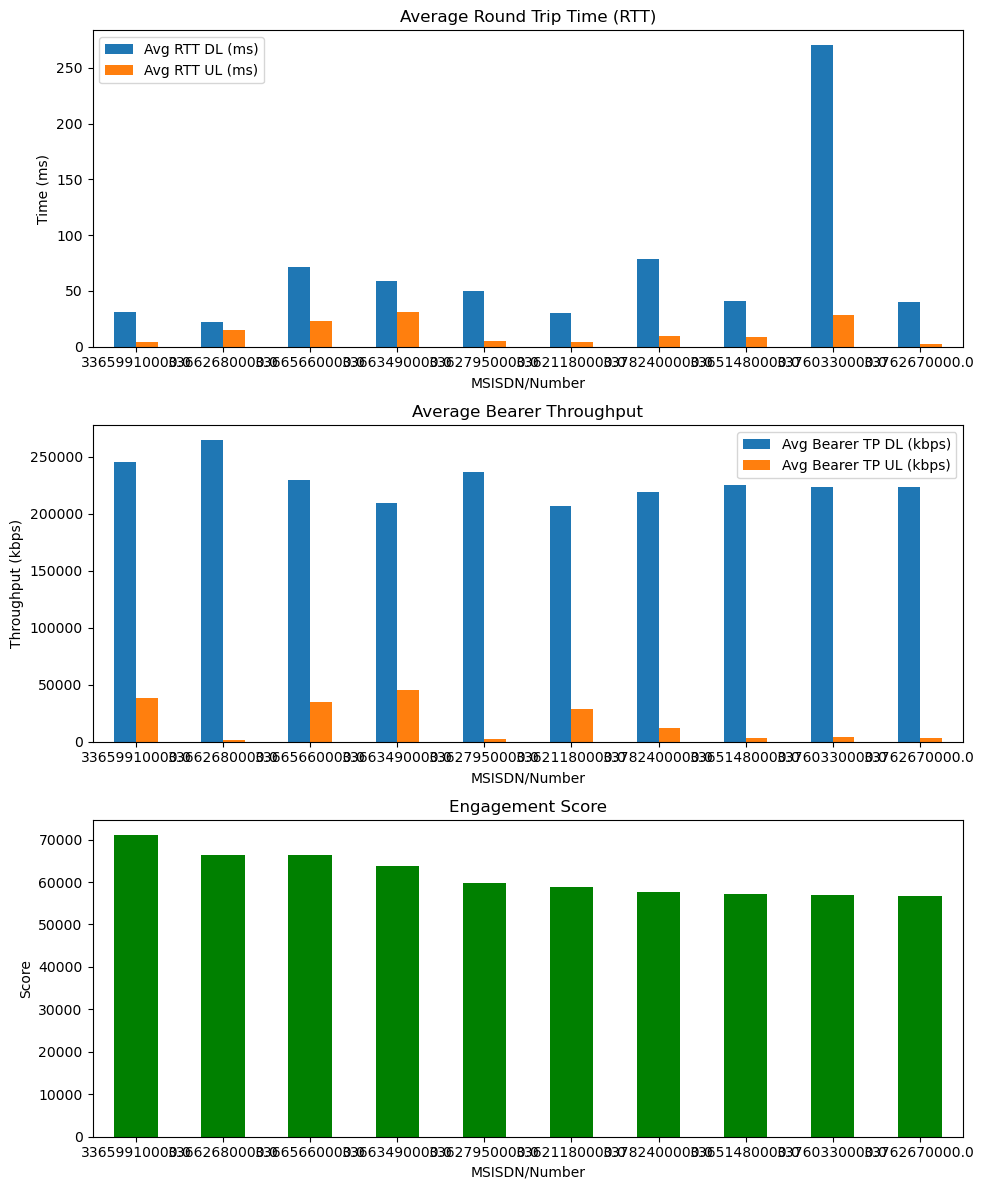

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Your data
data = {
    'MSISDN/Number': [3.365991e+10, 3.366268e+10, 3.366566e+10, 3.366349e+10, 3.362795e+10,
                      3.362118e+10, 3.378240e+10, 3.365148e+10, 3.376033e+10, 3.376267e+10],
    'Avg RTT DL (ms)': [31.0, 22.0, 71.0, 59.0, 50.0, 30.0, 79.0, 41.0, 270.0, 40.0],
    'Avg RTT UL (ms)': [4.0, 15.0, 23.0, 31.0, 5.0, 4.0, 10.0, 9.0, 28.0, 2.0],
    'Avg Bearer TP DL (kbps)': [245347.0, 264448.0, 230084.0, 209672.0, 236507.0,
                                206538.0, 218742.0, 225035.0, 223533.0, 223224.0],
    'Avg Bearer TP UL (kbps)': [38584.0, 1276.0, 35092.5, 45278.0, 2475.0,
                                28827.0, 12240.0, 3268.0, 3801.0, 3281.0],
    'Engagement Score': [70991.5, 66440.25, 66317.625, 63760.0, 59759.25,
                         58849.75, 57767.75, 57088.25, 56908.0, 56636.75]
}

df = pd.DataFrame(data)
df.set_index('MSISDN/Number', inplace=True)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Avg RTT
df[['Avg RTT DL (ms)', 'Avg RTT UL (ms)']].plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Average Round Trip Time (RTT)')
axes[0].set_ylabel('Time (ms)')

# Bearer Throughput
df[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title('Average Bearer Throughput')
axes[1].set_ylabel('Throughput (kbps)')

# Engagement Score
df['Engagement Score'].plot(kind='bar', ax=axes[2], rot=0, color='green')
axes[2].set_title('Engagement Score')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

In [10]:
#Normalize Engagement Metrics and Run K-Means (k=3)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Assuming 'mydata' is your DataFrame

# Define engagement metrics
engagement_metrics = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']

# Aggregate metrics per customer
customer_engagement = mydata.groupby('MSISDN/Number')[engagement_metrics].mean()

# Fill missing values with mean (you can choose a different strategy if needed)
imputer = SimpleImputer(strategy='mean')
customer_engagement_imputed = pd.DataFrame(imputer.fit_transform(customer_engagement), columns=customer_engagement.columns, index=customer_engagement.index)

# Normalize engagement metrics
scaler = StandardScaler()
normalized_engagement = scaler.fit_transform(customer_engagement_imputed)

# Run K-Means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
customer_engagement_imputed['Cluster'] = kmeans.fit_predict(normalized_engagement)

# Compute non-normalized metrics for each cluster
cluster_metrics = customer_engagement_imputed.groupby('Cluster')[engagement_metrics].agg(['min', 'max', 'mean', 'sum'])
print(cluster_metrics)



/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


        Avg RTT DL (ms)                                    Avg RTT UL (ms)  \
                    min      max        mean           sum             min   
Cluster                                                                      
0                   0.0  96923.0  125.880514  1.157043e+07             0.0   
1                  15.0   8293.0   77.899829  1.147309e+06             1.0   
2                   0.0   3157.0   83.314542  1.766268e+04           686.0   

                                            Avg Bearer TP DL (kbps)            \
             max         mean           sum                     min       max   
Cluster                                                                         
0         678.00    12.274508  1.128224e+06                     0.0   46460.0   
1         687.75    25.628050  3.774499e+05                   221.0  264448.0   
2        7120.00  1351.047956  2.864222e+05                     1.0   53422.0   

                                    Avg Bear

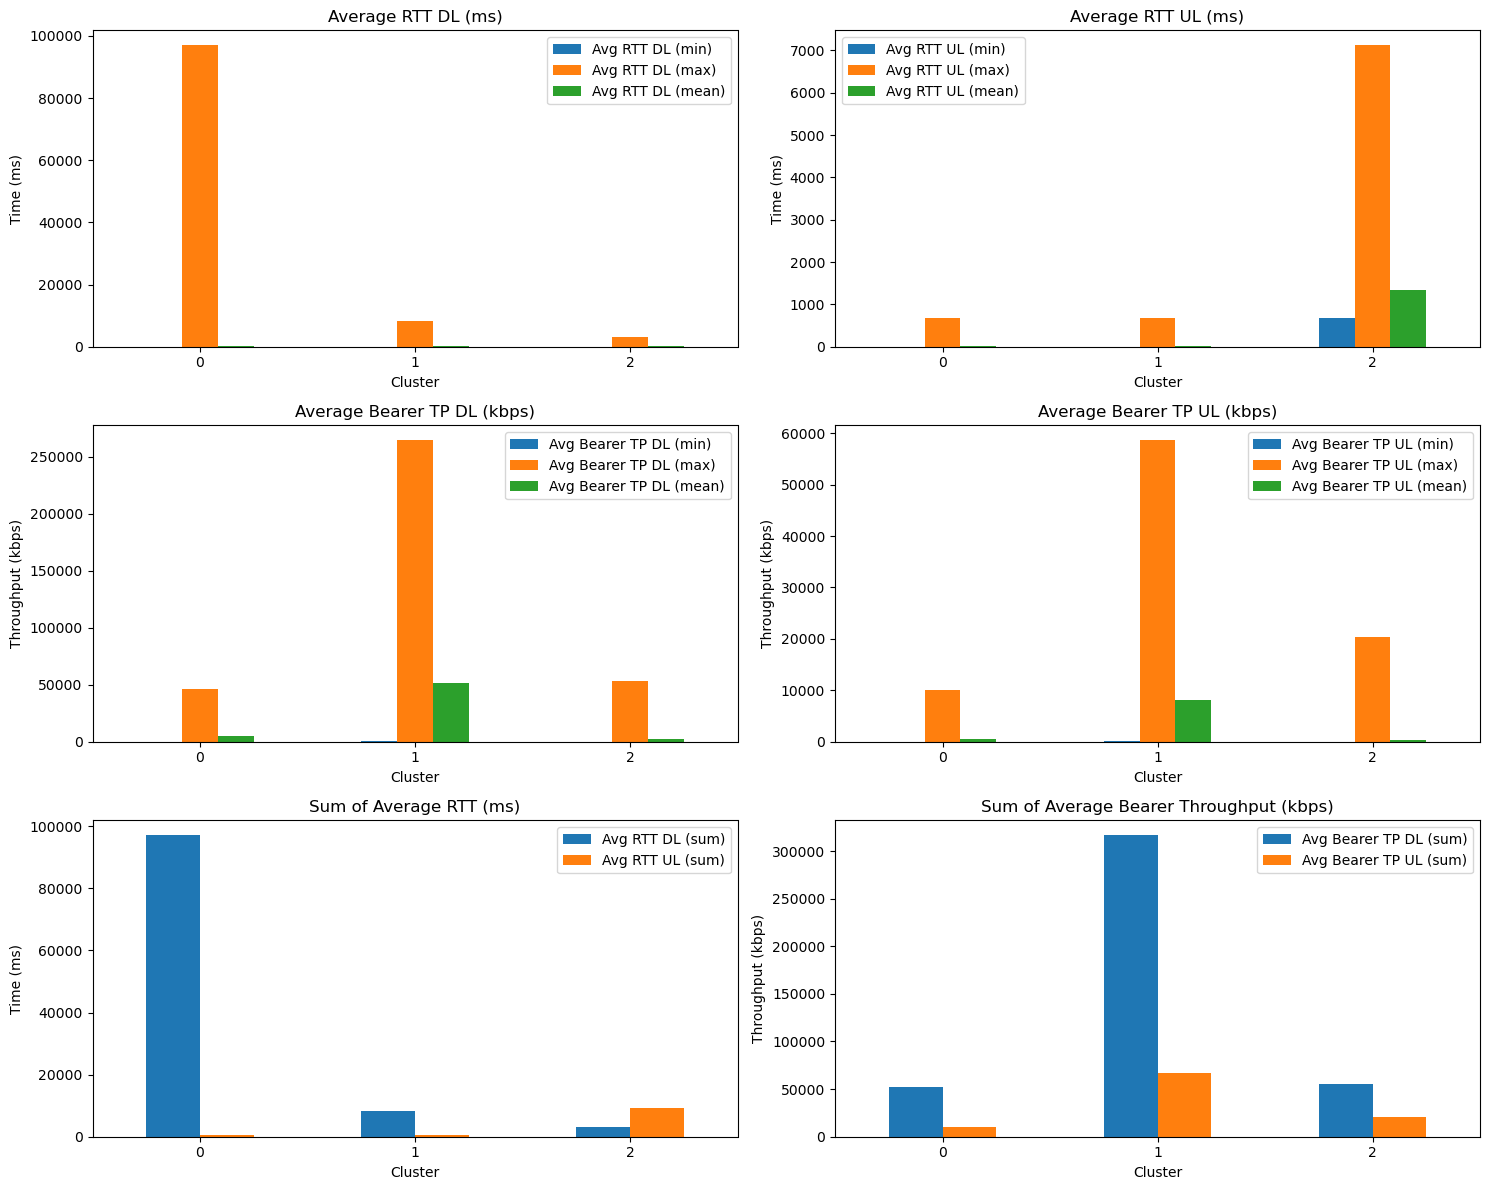

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Your data
data = {
    'Cluster': [0, 1, 2],
    'Avg RTT DL (min)': [0.0, 15.0, 0.0],
    'Avg RTT DL (max)': [96923.0, 8293.0, 3157.0],
    'Avg RTT DL (mean)': [125.880514, 77.899829, 83.314542],
    'Avg RTT UL (min)': [0.0, 1.0, 686.0],
    'Avg RTT UL (max)': [678.0, 687.75, 7120.0],
    'Avg RTT UL (mean)': [12.274508, 25.62805, 1351.047956],
    'Avg Bearer TP DL (min)': [0.0, 221.0, 1.0],
    'Avg Bearer TP DL (max)': [46460.0, 264448.0, 53422.0],
    'Avg Bearer TP DL (mean)': [5232.76374, 51718.505033, 2253.128931],
    'Avg Bearer TP UL (min)': [0.0, 176.0, 2.0],
    'Avg Bearer TP UL (max)': [10116.0, 58613.0, 20407.0],
    'Avg Bearer TP UL (mean)': [473.461245, 8060.65987, 307.783019],
}

df = pd.DataFrame(data)
df.set_index('Cluster', inplace=True)

# Calculate additional statistics
df['Avg RTT DL (sum)'] = df[['Avg RTT DL (min)', 'Avg RTT DL (max)', 'Avg RTT DL (mean)']].sum(axis=1)
df['Avg RTT UL (sum)'] = df[['Avg RTT UL (min)', 'Avg RTT UL (max)', 'Avg RTT UL (mean)']].sum(axis=1)
df['Avg Bearer TP DL (sum)'] = df[['Avg Bearer TP DL (min)', 'Avg Bearer TP DL (max)', 'Avg Bearer TP DL (mean)']].sum(axis=1)
df['Avg Bearer TP UL (sum)'] = df[['Avg Bearer TP UL (min)', 'Avg Bearer TP UL (max)', 'Avg Bearer TP UL (mean)']].sum(axis=1)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Avg RTT DL
df[['Avg RTT DL (min)', 'Avg RTT DL (max)', 'Avg RTT DL (mean)']].plot(kind='bar', ax=axes[0, 0], rot=0)
axes[0, 0].set_title('Average RTT DL (ms)')
axes[0, 0].set_ylabel('Time (ms)')

# Avg RTT UL
df[['Avg RTT UL (min)', 'Avg RTT UL (max)', 'Avg RTT UL (mean)']].plot(kind='bar', ax=axes[0, 1], rot=0)
axes[0, 1].set_title('Average RTT UL (ms)')
axes[0, 1].set_ylabel('Time (ms)')

# Avg Bearer TP DL
df[['Avg Bearer TP DL (min)', 'Avg Bearer TP DL (max)', 'Avg Bearer TP DL (mean)']].plot(kind='bar', ax=axes[1, 0], rot=0)
axes[1, 0].set_title('Average Bearer TP DL (kbps)')
axes[1, 0].set_ylabel('Throughput (kbps)')

# Avg Bearer TP UL
df[['Avg Bearer TP UL (min)', 'Avg Bearer TP UL (max)', 'Avg Bearer TP UL (mean)']].plot(kind='bar', ax=axes[1, 1], rot=0)
axes[1, 1].set_title('Average Bearer TP UL (kbps)')
axes[1, 1].set_ylabel('Throughput (kbps)')

# Additional Statistic
df[['Avg RTT DL (sum)', 'Avg RTT UL (sum)']].plot(kind='bar', ax=axes[2, 0], rot=0)
axes[2, 0].set_title('Sum of Average RTT (ms)')
axes[2, 0].set_ylabel('Time (ms)')

df[['Avg Bearer TP DL (sum)', 'Avg Bearer TP UL (sum)']].plot(kind='bar', ax=axes[2, 1], rot=0)
axes[2, 1].set_title('Sum of Average Bearer Throughput (kbps)')
axes[2, 1].set_ylabel('Throughput (kbps)')

plt.tight_layout()
plt.show()


In [6]:
#Aggregate User Total Traffic Per Application and Derive Top 10 Most Engaged Users Per Application
# List of application columns
application_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 
                        'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']

# Aggregate total traffic per application per customer
user_application_traffic = mydata.groupby('MSISDN/Number')[application_columns].sum()

# Derive top 10 most engaged users per application
top_10_users_per_application = {}
for app_column in application_columns:
    top_10_users_per_application[app_column] = user_application_traffic.nlargest(10, app_column)

# Print or further analyze top users per application
for app_column, top_users in top_10_users_per_application.items():
    print(f"Top 10 users for {app_column}:")
    print(top_users)


Top 10 users for Social Media DL (Bytes):
               Social Media DL (Bytes)  Google DL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                                 
3.362632e+10                42743837.0        116106455.0        33404785.0   
3.376054e+10                39297646.0         88626532.0        26437895.0   
3.365973e+10                34900444.0         90958549.0        29907647.0   
3.361489e+10                27749744.0         93941708.0        33607211.0   
3.362578e+10                26564121.0        107904739.0        31895412.0   
3.366716e+10                23753753.0         71707826.0        23276752.0   
3.378632e+10                23568655.0         78819810.0        30876908.0   
3.366907e+10                23477047.0         54915216.0        17813584.0   
3.360313e+10                22776679.0         73942055.0        20343728.0   
3.365849e+10                22695673.0         55457602.0        15004556.0   

         

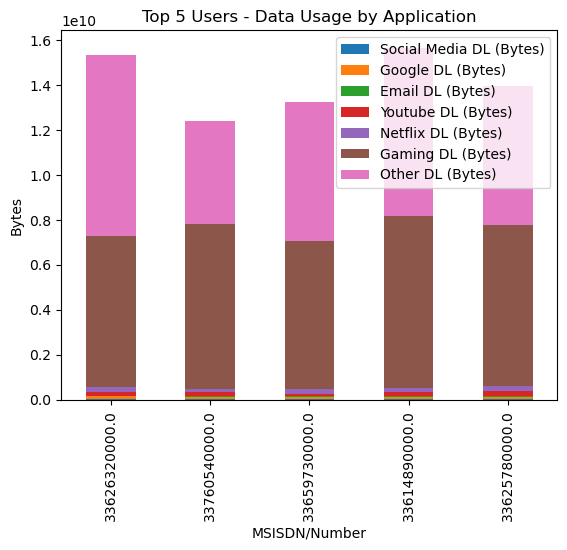

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Example:
data = {
    'MSISDN/Number': [3.362632e+10, 3.376054e+10, 3.365973e+10, 3.361489e+10, 3.362578e+10],
    'Social Media DL (Bytes)': [42743837.0, 39297646.0, 34900444.0, 27749744.0, 26564121.0],
    'Google DL (Bytes)': [116106455.0, 88626532.0, 90958549.0, 93941708.0, 107904739.0],
    'Email DL (Bytes)': [33404785.0, 26437895.0, 29907647.0, 33607211.0, 31895412.0],
    'Youtube DL (Bytes)': [164048706.0, 194068298.0, 119658146.0, 199823443.0, 237883033.0],
    'Netflix DL (Bytes)': [199479238.0, 146500839.0, 196277206.0, 179585986.0, 193912238.0],
    'Gaming DL (Bytes)': [6.745734e+09, 7.316364e+09, 6.609900e+09, 7.622035e+09, 7.171884e+09],
    'Other DL (Bytes)': [8.025477e+09, 4.590038e+09, 6.182551e+09, 7.495298e+09, 6.201653e+09],
}

df = pd.DataFrame(data)

# Plot histograms
df.plot(x='MSISDN/Number', kind='bar', stacked=True)
plt.xlabel('MSISDN/Number')
plt.ylabel('Bytes')
plt.title('Top 5 Users - Data Usage by Application')
plt.show()



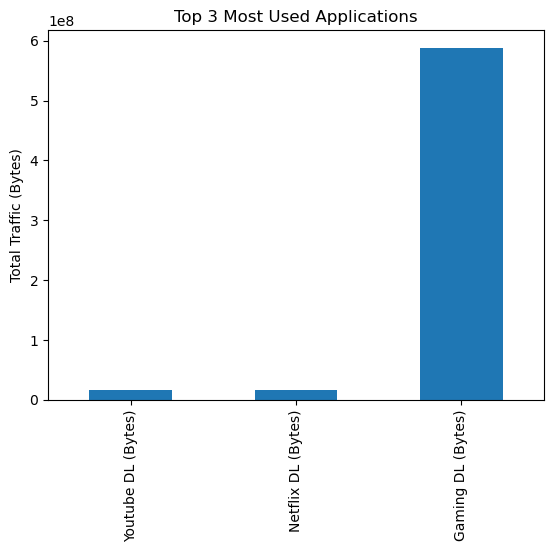

In [7]:
#Plot Top 3 Most Used Applications
import matplotlib.pyplot as plt

# Assuming you have the top 3 application columns
top_3_applications = ['Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)']

# Plot bar chart for top 3 applications
mydata_top_3 = mydata[['MSISDN/Number'] + top_3_applications]
mydata_top_3_sum = mydata_top_3.groupby('MSISDN/Number')[top_3_applications].sum()

mydata_top_3_sum.mean().plot(kind='bar', title='Top 3 Most Used Applications')
plt.ylabel('Total Traffic (Bytes)')
plt.show()


/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

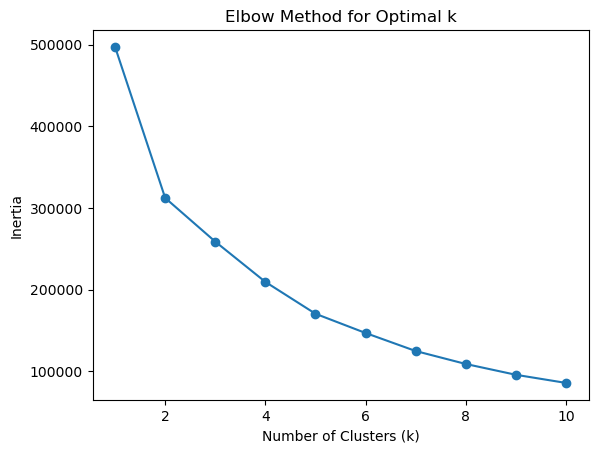

In [9]:
#Determine Optimized Value of k for K-Means (Elbow Method)
from sklearn.impute import SimpleImputer

# Assuming 'normalized_engagement' is your feature matrix

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like median, constant, etc.
normalized_engagement_imputed = imputer.fit_transform(normalized_engagement)

# Run K-Means
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_engagement_imputed)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

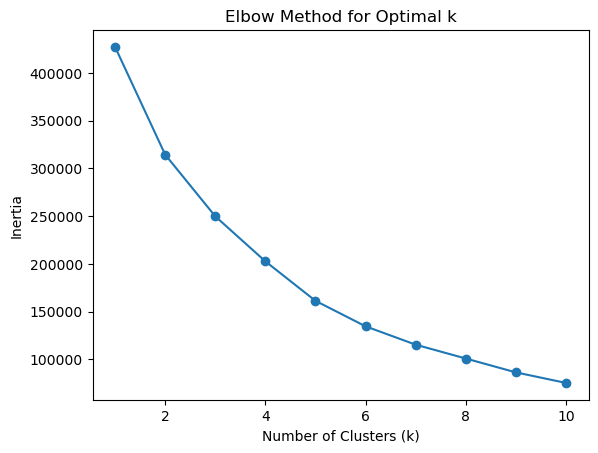

In [19]:
from sklearn.impute import SimpleImputer

# Assuming 'normalized_engagement' is your feature matrix

# Impute missing values
imputer = SimpleImputer(strategy='constant')  # You can use other strategies like median, constant, etc.
normalized_engagement_imputed = imputer.fit_transform(normalized_engagement)

# Run K-Means
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_engagement_imputed)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()